In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Import packages
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep
import os

#Import Custom Classes

from Source.nn_model_dqn import QNetwork
from Source.dqn_rcv_agent import Agent, ReplayBuffer, EpsilonGreedyStrategy
from Source.env_manager import EnvManager
from Source.misc_fun.utils import plot, get_moving_average, Generate_BeamDir, All_Exhaustive_RateMeas
from Source.PER import PrioritizedReplayBuffer

In [3]:
#Hyper-parameters
BUFFER_SIZE = int(1e5)      #replay buffer size
BATCH_SIZE = 128             #minibatch size
GAMMA = 0.999                #discount factor
ALPHA = 1.0                  #non-stationarity parameter
TAU = 1e-3                  #for soft update of target parameters
LR = 5e-4                   #learning rate
TEST_EVERY = 1600            #how often to test the network
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.9987 #125e-6
PER_ALPHA = 0.6
PER_BETA = 0.4
PRIORITIZED_REPLAY = False

episodes = 4200 #3100 train, 500 test
seed = 0                    #random seed number
#%%
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inp_fptr = open("ricianch_variation.txt")
ch_randvals = inp_fptr.read().splitlines()
ch_randvals = [np.complex(a.replace('i','j')) for a in ch_randvals]

In [4]:
print(ch_randvals[0])

#print(np.complex(ch_randvals[0].replace('i','j')))

(1.1128+0.0082264j)


Beamset: [(0.39269908, 8) (0.78539816, 8) (1.17809725, 8) (1.57079633, 8)
 (1.96349541, 8) (2.35619449, 8) (2.74889357, 8) (3.14159265, 8)
 (0.78539816, 4) (1.57079633, 4) (2.35619449, 4) (3.14159265, 4)]
Ntx: 8, active Ntx: 4, Beam: [ 0.35355339+0.00000000e+00j -0.35355339-4.32978028e-17j
  0.35355339+8.65956056e-17j -0.35355339-1.29893408e-16j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j]


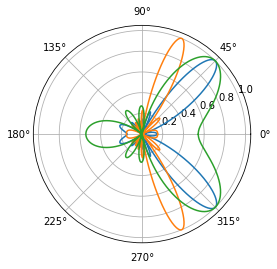

In [5]:
#Testing (beam_dir, beam_width) Beamset
from Source.antenna.ula import var_steervec
from Source.misc_fun.utils import Generate_Beams, var_plotbeam

width_vec = np.array([np.pi/8, np.pi/4])
beamset = Generate_Beams(8,width_vec)

print("Beamset: {}".format(beamset))

tx_beam = var_steervec(8,beamset[11], 0)
print("Ntx: {}, active Ntx: {}, Beam: {}".format(8, 4, tx_beam))

theta, gr = var_plotbeam(beamset[1], 8)
theta2, gr2 = var_plotbeam(beamset[2], 8)
theta3, gr3 = var_plotbeam(beamset[8], 4)
ax = plt.subplot(111, projection='polar')
##print(theta.shape, gr.shape)
ax.plot(theta, gr, theta2, gr2, theta3, gr3)
plt.show()
    

In [6]:
#Choose the environment
em = EnvManager(device, 'combrf-v9', seed)
available_actions = em.num_actions_available()
random.seed(seed)
state_size = em.state_size()
print(em.env.ch_model)
print(em.env.sc_xyz)
#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 500)

if PRIORITIZED_REPLAY:
    beta_strategy = EpsilonGreedyStrategy(PER_BETA, 1.0, eps_decay, 3500)

#Initialize the agent
agent = Agent(strategy, state_size, available_actions, seed, device)

#Instantiate MemoryBuffer
if not PRIORITIZED_REPLAY:
    memory = ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)
else:
    memory = PrioritizedReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, PER_ALPHA,seed, device)

policy_net = QNetwork(state_size, available_actions, seed).to(device)
target_net = QNetwork(state_size, available_actions, seed).to(device)
print(policy_net)

#Initialize target_net weights to policy_net weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #Set the target_net in eval mode

#Select the optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)

uma-los
[]
QNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=3, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=64, bias=True)
  )
  (softmax): Softmax(dim=1)
  (output): Linear(in_features=64, out_features=144, bias=True)
)


In [7]:
print("tx_locs: {}".format(em.env.tx_locs))

tx_locs: [array([[-100. , -100. ,    1.5]]), array([[-100. , -100. ,   11.5]]), array([[-100. , -100. ,   21.5]]), array([[-100. ,    0. ,    1.5]]), array([[-100. ,    0. ,   11.5]]), array([[-100. ,    0. ,   21.5]]), array([[   0. , -100. ,    1.5]]), array([[   0. , -100. ,   11.5]]), array([[   0. , -100. ,   21.5]]), array([[0. , 0. , 1.5]]), array([[ 0. ,  0. , 11.5]]), array([[ 0. ,  0. , 21.5]])]


In [8]:
print("Beamset: {}".format(em.env.BeamSet))

Beamset: [(0.39269908, 8) (0.78539816, 8) (1.17809725, 8) (1.57079633, 8)
 (1.96349541, 8) (2.35619449, 8) (2.74889357, 8) (3.14159265, 8)
 (0.78539816, 4) (1.57079633, 4) (2.35619449, 4) (3.14159265, 4)]


## Test with random untrained actions

In [9]:
obs = em.env.reset(np.exp(1j * 2 * np.pi * 0.6))
#print(len(em.env.beamwidth_vec))
#print(em.env.action_space.n)
print(obs)
ep_rwd=[]
while True:
    action = random.randrange(em.env.action_space.n)
    
    obs, rwd, done, _ = em.env.step(action)
    print(action)
    ep_rwd.append(rwd)
    if done:
        break
        
print("Episode score: {}".format(np.sum(ep_rwd)))

[[0.         0.         0.95555556]]
98
107
10
66
130
124
103
77
122
91
55
129
35
72
35
24
64
136
37
79
25
18
84
120
143
25
90
111
80
52
141
122
113
133
66
15
140
3
23
102
0
126
85
62
83
16
48
56
61
36
139
114
23
20
81
130
125
27
77
141
74
31
140
85
Episode score: -62.0


In [10]:
moving_rpts = [[np.array([rp_loc])] for rp_loc in em.env.sc_xyz]

#print("Initial: \n", moving_rpts)

for i in range(2):
    for ndx in range(len(moving_rpts)):
        if (ndx == 0) or (ndx == 1):
            last_loc = moving_rpts[ndx][-1]
            new_loc = np.array([[last_loc[0][0]+em.env.rx_stepsize, last_loc[0][1], last_loc[0][2]]]) 
            moving_rpts[ndx].append(new_loc)
        elif (ndx == 2) or (ndx == 3):
            last_loc = moving_rpts[ndx][-1]
            new_loc = np.array([[last_loc[0][0], last_loc[0][1]-em.env.rx_stepsize, last_loc[0][2]]]) 
            moving_rpts[ndx].append(new_loc)

print("After adding moving patterns: ", moving_rpts)



After adding moving patterns:  []


In [11]:
eps_scpts = []

for i in range(episodes):
    #print(random.choice(moving_rpts[0]))
    sc_pts = np.array([random.choice(moving_rpts[ndx])[0] for ndx in range(len(moving_rpts))])
    eps_scpts.append(sc_pts)

#print(eps_scpts)

In [12]:
print(eps_scpts[7])

[]


## Train the DQN agent

In [13]:
ep_rewards = []
test_rewards = []
test_data_rates = []
test_eps_iters=[]
test_minexh_rates = []
test_maxexh_rates = []
false_positives =0
policy_net.train()
test_txbdir = 0
beam_ndx = 0
tx_num=0

strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 500)
outer = tqdm.notebook.tqdm(total=episodes, desc='training loop: ', position=0)
train_steps = 0
for episode in range(episodes):
    
    #if(eps <= 0.1):
    #    em.env.sc_xyz=np.array([])
    #    em.env.ch_model = 'uma-los'
    #if ((episode+1) == 3500):
    #    em.env.ch_model = 'uma-los'
    #    em.env.sc_xyz = np.array([])
        #train_steps = 0
        #strategy =EpsilonGreedyStrategy(1.0, eps_end, 0.997)#0.1
    #if ((episode+1) == 3900):
    #    train_steps=0
    #    strategy =EpsilonGreedyStrategy(1.0, eps_end, 0.9983, 3500)#0.1
    #    if PRIORITIZED_REPLAY:
    #        beta_strategy = EpsilonGreedyStrategy(PER_BETA, 1.0, eps_decay, 3500)
    #em.env.sc_xyz = eps_scpts[episode]
    #if (episode+1) == 4100:
    #    obs_tensor = torch.tensor(np.array([[-100,-100,21.5]]), device=device, dtype=torch.float32)
    #    print("TXloc: {}, obs_tensor: {}".format(np.array([[-100,-100,21.5]]), obs_tensor))
    #    for action in range(em.env.action_space.n):
    #        action_tensor = torch.tensor([action]).to(device)
    #        learnt_qval = policy_net(obs_tensor).gather(1,index=action_tensor)
    #        print("action: {}, learnt_qval: {}".format(action, learnt_qval))
        
    if ((episode+1) >= 4100):    
        obs = em.test_reset(em.env.tx_locs[tx_num],em.env.sc_xyz, ch_randvals[episode])#np.array([[-100,-100,21.5]])
        #test_txbdir = (test_txbdir + 1) % em.env.obs_space.nvec[3]
        #beam_ndx = (beam_ndx +1) % em.env.action_space.n
        tx_num = (tx_num + 1) % len(em.env.tx_locs)
    else:
        obs = em.reset(ch_randvals[episode])

    
    ep_loss = 0.0
    ep_rwd = 0.0
    timestep = 0
    tx_dirs = []
    rx_dirs = []
    data_rates =[]
    #agent.current_step +=1
    train_steps +=1
    eps = strategy.get_exploration_rate(train_steps)
    if PRIORITIZED_REPLAY:
        beta = beta_strategy.get_exploration_rate(train_steps)
    
    while True:
        tx_dirs.append((em.env.tx_bdir[0]*(180/np.pi), em.env.tx_bdir[1]))
        rx_dirs.append((em.env.rx_bdir[0]*(180/np.pi), em.env.rx_bdir[1]))
        data_rates.append(em.env.rate)

        action = agent.act(obs, policy_net, eps)
        next_obs, reward, done, _ = em.step(action)
        #agent.step(obs, action, reward, next_obs, done)
        ep_rwd += reward.item()
        
        min_exh_rate, max_exh_rate,(min_txaction_ndx, min_rxaction_ndx),(max_txaction_ndx, max_rxaction_ndx) = em.env.get_minmax_exhrate(ch_randvals[episode])
        '''
        if(np.all(em.env.tx_loc == np.array([[100,100,0]]))):
            print("ch_model: {}, sc_xyz: {}, min_exh_rate: {}, max_exh_rate: {}, min_action_ndx: {}, max_action_ndx: {}".format(em.env.ch_model, em.env.sc_xyz, min_exh_rate, max_exh_rate, min_action_ndx, max_action_ndx))
        '''   
        memory.add(obs, action, reward, next_obs, done)
        obs = next_obs
        
        if memory.can_provide_sample():
            
            if PRIORITIZED_REPLAY:
                experiences = memory.sample(beta)
                observations, actions, rewards, next_observations, dones, weights, batch_indices = experiences
            else:
                experiences = memory.sample()
                observations, actions, rewards, next_observations, dones = experiences
                weights, batch_indices = torch.tensor(np.ones_like(rewards.cpu().data.numpy())).to(device), None
            
            #print(states.shape, states.dtype)
            #print(actions.unsqueeze(-1).shape)
            current_q_values = policy_net(observations).gather(1,index=actions.unsqueeze(-1))#(1-ALPHA)*
            
            next_q_values = target_net(next_observations).detach().max(1)[0]
            target_q_values = ((next_q_values*GAMMA) + rewards)
            #print(policy_net(observations).type())
            #print(target_q_values.unsqueeze(1).type())
            #loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float())
            td_errors = ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values)
            loss = F.mse_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction=None)
            #weighted_loss = torch.mean(weights*loss)
            #print("loss: ", loss)
            #loss = ALPHA*loss
            #ep_loss += weighted_loss.item()
            ep_loss += loss.item()
            
            optimizer.zero_grad()
            #weighted_loss.backward()
            loss.backward()
            optimizer.step()
            
            if PRIORITIZED_REPLAY:
                comp_errors = np.array([x[0] for x in td_errors.cpu().data.numpy()])
                new_priorities = np.abs(comp_errors) + 1e-6
                #print(new_priorities)
                memory.update_priorities(batch_indices.cpu().data.numpy(), new_priorities)
            
        timestep +=1
        if done:
            ep_rewards.append(ep_rwd)
            moving_avg_rwd = get_moving_average(100, ep_rewards)
            print('\rEpisode {},\tScore: {:.2f}, eps: {}, moving avg_rwd: {}, ep_loss: {}'.format(episode+1, ep_rwd, eps, moving_avg_rwd[-1], ep_loss), end="\r")
            #plot(episode_rewards, 100)
            
            #if(((episode+1) >= 6000) or (3000 <= (episode+1)<=3500)):
            if((episode+1) >= 4100):
                
                test_data_rates.append(data_rates[-1])
                test_eps_iters.append(timestep)
                test_minexh_rates.append(min_exh_rate)
                test_maxexh_rates.append(max_exh_rate)
                
                #if (timestep > 3):
                #    if(timestep >=8):
                #        false_positives +=1
                #if (min_exh_rate == max_exh_rate):
                print("\ntest_eps: {0}, eps_rwd: {1}".format(episode+1, ep_rwd))
                print("TX loc: {}".format(em.env.tx_loc))
                print("SC_xyz: {}".format(em.env.sc_xyz))
                print("TX dirs: ", tx_dirs)
                print("RX dirs: ", rx_dirs)
                print("data rates: {}".format(data_rates))
                print("min exh_rate: {}, min_txaction_ndx: {},beamset val: ({},{}),  min_rxaction_ndx: {}, beamset val: ({},{})".format(min_exh_rate, min_txaction_ndx, em.env.BeamSet[min_txaction_ndx][0]*180/np.pi,em.env.BeamSet[min_txaction_ndx][1], min_rxaction_ndx,em.env.BeamSet[min_rxaction_ndx][0]*180/np.pi,em.env.BeamSet[min_rxaction_ndx][1]))
                print("max exh_rate: {}, max_txaction_ndx: {}, beamset val: ({},{}), max_rxaction_ndx: {}, beamset val: ({},{})\n".format(max_exh_rate, max_txaction_ndx, em.env.BeamSet[max_txaction_ndx][0]*180/np.pi, em.env.BeamSet[max_txaction_ndx][1], max_rxaction_ndx,em.env.BeamSet[max_rxaction_ndx][0]*180/np.pi, em.env.BeamSet[max_rxaction_ndx][1]))
                
            timestep = 0
            break
            
        #print("timestep: {}".format(timestep))
    #if episode % UPDATE_EVERY == 0:
    #    target_net.load_state_dict(policy_net.state_dict())
    for local_param, target_param in zip(policy_net.parameters(), target_net.parameters()):
        target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)
        
    # update tqdm bar
    outer.update(1)
    
torch.save(policy_net.state_dict(), 'checkpoint.pth')

#timer.finish()
plot(ep_rewards, 200, test_rewards)
print("No. of false positives: {}".format(false_positives))

RuntimeError: Expected object of scalar type int but got scalar type __int64 for sequence element 2.

In [ ]:
fig=plt.figure()
min_ndx=0
max_ndx=500
plt.plot(test_eps_iters[min_ndx:max_ndx])
plt.show()
print(np.mean(test_eps_iters), len(test_eps_iters))

In [ ]:
print(em.env.ch_model)
print(em.env.sc_xyz)

In [ ]:
fig = plt.figure(figsize=[9, 6])
min_ndx=24
max_ndx=48
plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), test_data_rates[min_ndx:max_ndx], 'b', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_minexh_rates[min_ndx:max_ndx], 'r--', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'g--')
#plt.plot(np.arange(len(test_data_rates[3080:3140])), test_data_rates[3080:3140], 'b', np.arange(len(test_data_rates[3080:3140])), test_minexh_rates[3080:3140], 'r--', np.arange(len(test_data_rates[3080:3140])), test_maxexh_rates[3080:3140],'g--')
#plt.plot(np.arange(len(test_data_rates[4650:4740])), test_data_rates[4650:4740], 'b', np.arange(len(test_data_rates[4650:4740])), test_minexh_rates[4650:4740], 'r--', np.arange(len(test_data_rates[4650:4740])), test_maxexh_rates[4650:4740],'g--')
#plt.plot(np.arange(len(test_data_rates[6230:])), test_data_rates[6230:], 'b', np.arange(len(test_data_rates[6230:])), test_minexh_rates[6230:], 'r--', np.arange(len(test_data_rates[6230:])), test_maxexh_rates[6230:],'g--')

plt.xticks(np.arange(0, max_ndx-min_ndx), [str(x) for x in np.arange(min_ndx, max_ndx)])
plt.legend(['learnt rate','min exhrate', 'max exhrate'])
plt.xlabel('Episode #')
plt.ylabel('data rate (bits/s)')
plt.title('Beam alignment with episode length:{}'.format(em.env.goal_steps))
plt.show()

In [ ]:
min_ndx=60
max_ndx=80
print(test_data_rates[min_ndx:max_ndx])
print(test_maxexh_rates[min_ndx:max_ndx])


In [ ]:
print(test_data_rates[69])
print([(x[0]*180/np.pi, x[1]) for x in em.env.BeamSet])
#print(em.env.BeamSet[9])

In [ ]:
print(em.env.dqnobs_counter)
print(len(em.env.dqnobs_counter))
print(np.mean(em.env.dqnobs_counter))

In [ ]:
#import pickle

#memory.save('memory_checkpoint.pth')
plot(ep_rewards, 100, test_rewards)
print(ep_rewards[:100])
moving_avg_rwd = get_moving_average(100, ep_rewards[:100])
print(moving_avg_rwd)

## Test the DQN agent

In [ ]:
from Source.misc_fun.utils import var_plotbeam

print(tx_dirs)
print(rx_dirs)
for tx_ang, rx_ang in zip(tx_dirs, rx_dirs):
    tx_theta, tx_gr = var_plotbeam(tx_ang, em.env.N_tx)
    rx_theta, rx_gr = var_plotbeam(rx_ang, em.env.N_rx)
    ax1 = plt.subplot(122, projection='polar')
    ax1.plot(tx_theta, tx_gr)

    ax2 = plt.subplot(121, projection='polar')
    ax2.plot(rx_theta, rx_gr)

    plt.show()




## Display all exhaustive rate measurements from env

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

fig = plt.figure()
ax = fig.gca(projection='3d')
poly = PolyCollection(verts[:4], facecolors=['r', 'g', 'b', 'y'], alpha=0.6)
print(len(verts))
print(verts[0:2])
#print(np.array(tx_locs[:4]))
ax.add_collection3d(poly, zs=np.arange(1,5), zdir='y')

ax.set_xlabel('X (beam pairs)')
ax.set_ylabel('Y (tx_locs)')
ax.set_zlabel('Z (data rates)')
ax.set_xlim(0, 10)
ax.set_ylim(1, 5)
ax.set_zlim(10, 30)

plt.show()

In [ ]:
print(em.env.ch_model)
print(em.env.sc_xyz)
em.env.BeamSet[5][0]*180/np.pi
np.arctan(1100/200)*180/np.pi

In [ ]:
12/24, 14/24

from Source.misc_fun.utils import plotbeam

tx_theta, tx_gr = plotbeam(exh_txbeams[0]*(np.pi/180), em.env.N_tx)
rx_theta, rx_gr = plotbeam(exh_rxbeams[0]*(np.pi/180), em.env.N_rx)
ax1 = plt.subplot(122, projection='polar')
ax1.plot(tx_theta, tx_gr)

ax2 = plt.subplot(121, projection='polar')
ax2.plot(rx_theta, rx_gr)

plt.show()

